In [ ]:
import numpy as np 
import pandas as pd 


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import zipfile

# Reading CSV

In [4]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# Label Encoding

In [6]:
def encode(df_train):
    le = LabelEncoder().fit(df_train.species)
    labels = le.transform(df_train.species) 
    
    classes = list(le.classes_) 
    
    
    
    df_train = df_train.drop(['species','id'],axis = 1) 
    

    return df_train, labels, classes

df_train, labels, classes = encode(df_train)

In [7]:
X = df_train.values
y = labels

# PCA for dimensionality reduction

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle', svd_solver='full')

X=pca.fit_transform(X)
n_components = pca.n_components_

#Spliting the dataset into Training, Validation and Testing

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=5)
split.get_n_splits(X, y)
for train_index, test_index in split.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=5)
for train_val_index, val_index in split.split(X_train, y_train):
   


    X_train_val, X_val = X_train[train_val_index], X_train[val_index]
    y_train_val, y_val = y_train[train_val_index], y_train[val_index] 

#Decision tree classifier training 

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss

DT_clf = DecisionTreeClassifier()
DT_clf.fit(X_train_val, y_train_val) 


predictions_val_DT = DT_clf.predict(X_val)  
acc_val_DT = accuracy_score(y_val, predictions_val_DT)
print("Validation Accuracy: {:.4%}".format(acc_val_DT))

predictions_prob_val_DT = DT_clf.predict_proba(X_val) 
ll_val_DT = log_loss(y_val, predictions_prob_val_DT) 
print("Validation Log Loss: {}".format(ll_val_DT))

Validation Accuracy: 41.5094%
Validation Log Loss: 20.201925815891254


# 5 Fold cross validation 

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(DT_clf, X_train, y_train, cv=5, scoring='f1_micro')
print(DT_clf,scores)
print("Cross Validation Avg Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

DecisionTreeClassifier() [0.50314465 0.40880503 0.50632911 0.46835443 0.43670886]
Cross Validation Avg Accuracy: 0.46 (+/- 0.08)


In [ ]:
from sklearn.metrics import classification_report
report_RF = classification_report(y_val, predictions_val_DT, target_names=classes)
print(report_RF)

In [14]:
predictions_T_val_DT = DT_clf.predict(X_train_val)
acc_T_val_DT = accuracy_score(y_train_val, predictions_T_val_DT)
print("Training Accuracy: {:.4%}".format(acc_T_val_DT))

Training Accuracy: 100.0000%


In [15]:
from sklearn.metrics import f1_score
f1scoreTrain = f1_score( y_train_val, predictions_T_val_DT, average='macro' )
f1scoreTest = f1_score( y_val, predictions_val_DT , average='macro')

print("F1-score for training:{}, for test:{}".format(f1scoreTrain, f1scoreTest) )

F1-score for training:1.0, for test:0.3561327561327561


In [ ]:
from sklearn import tree
plt.figure(figsize=(25,20))
tree.plot_tree(DT_clf)
plt.show()

#•	Fit the tree with different depths

F1-score for training:0.8342431642431641, F1-score for val:0.33436092527001615
F1-score for training:0.8659229702398425, F1-score for val:0.3522921522921522
F1-score for training:0.8858682671353012, F1-score for val:0.3657912457912458
F1-score for training:0.9035691581146126, F1-score for val:0.3712602212602213
F1-score for training:0.9152775600003294, F1-score for val:0.3558567036827907
F1-score for training:0.9265850474061618, F1-score for val:0.41107904441237775
F1-score for training:0.9349491071416205, F1-score for val:0.4162097162097162
F1-score for training:0.9419454728278257, F1-score for val:0.37715247715247713
F1-score for training:0.9516175743448471, F1-score for val:0.3601731601731602
F1-score for training:0.9581526217889855, F1-score for val:0.39894179894179893
F1-score for training:0.9639565821384003, F1-score for val:0.3901394901394901
F1-score for training:0.9678222747741465, F1-score for val:0.3838952293497748
F1-score for training:0.9727414000141273, F1-score for val:0

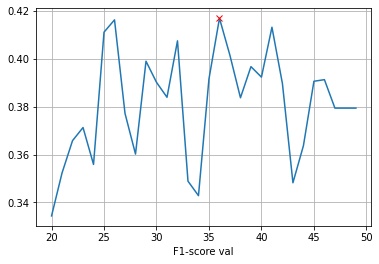

In [16]:
heights = np.arange(20,50)

F1scoreVal = np.zeros( len( heights) )



for idx in range( len( heights) ):
    
    clf = DecisionTreeClassifier(random_state=0, max_depth = heights[ idx] )
    clf.fit( X_train_val, y_train_val)

    predTrain = clf.predict(X_train_val)

    predVal = clf.predict(X_val)

    f1scoreTrain = f1_score( y_train_val, predTrain, average='macro' )
    f1scoreVal = f1_score( y_val, predVal , average='macro')

    
    F1scoreVal[ idx ] = f1scoreVal
    
    print("F1-score for training:{}, F1-score for val:{}".format(f1scoreTrain, f1scoreVal) )
    

maxF1 = np.argmax( F1scoreVal ) 
plt.figure()
plt.plot( heights, F1scoreVal )
plt.plot(heights[maxF1], F1scoreVal[maxF1], 'rx' )
plt.xlabel('depth')
plt.xlabel('F1-score val')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
print(clf,scores)
print("Cross Validation Avg Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
predictions_prob_val_DT_H = clf.predict_proba(X_val) 
ll_val_DT = log_loss(y_val, predictions_prob_val_DT_H)
print("Validation Log Loss: {}".format(ll_val_DT))

In [ ]:
acc_val_DT_H = accuracy_score(y_val, predVal)
print("Validation Accuracy: {:.4%}".format(acc_val_DT_H))

In [ ]:
uniValues, counts = np.unique(y_train , return_counts=True)
counts

#Effect of number of samples for spliting a node

In [ ]:
split = np.arange(4,8)

F1scoreVal = np.zeros( len( split) )

for idx in range( len( split) ):
    
    clf = DecisionTreeClassifier(random_state=0, min_samples_split = split[ idx] )
    clf.fit( X_train_val, y_train_val)

    predTrain = clf.predict(X_train_val)

    predVal = clf.predict(X_val)

    f1scoreTrain = f1_score( y_train_val, predTrain, average='macro' )
    f1scoreVal = f1_score( y_val, predVal , average='macro')

    
    F1scoreVal[ idx ] = f1scoreVal
    
    print("F1-score for training:{}, F1-score for val:{}".format(f1scoreTrain, f1scoreVal) )
    

maxF1 = np.argmax( F1scoreVal ) 
plt.figure()
plt.plot( split, F1scoreVal )
plt.plot(split[maxF1], F1scoreVal[maxF1], 'rx' )
plt.xlabel('max split')
plt.xlabel('F1-score val')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
print(clf,scores)
print("Cross Validation Avg Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))